In [6]:
import pandas as p
import numpy as n
import torch as t
import torch.nn as nn

p.set_option('display.max_rows', 1000)

In [7]:
df = p.read_csv('df_dump.csv')
artists = list(df[~p.isna(df['artist'])].drop_duplicates(['artist']).sort_values(['artist']).reset_index(drop=True)['artist'])
titles = list(df[~p.isna(df['title'])].drop_duplicates(['title']).sort_values(['artist']).reset_index(drop=True)['title'])

In [8]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;''"
n_letters = len(all_letters)

def unicodeToAscii(s):
    x = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
    
    if len(x)>0:
        return x.strip()

#
artists_fudged = list(filter(None,map(unicodeToAscii,artists)))
titles_fudged = list(filter(None,map(unicodeToAscii,titles)))

lines = artists_fudged

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = t.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = t.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor



In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(0 + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(0 + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        input_combined = t.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = t.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return t.zeros(1, self.hidden_size)
    
def inputTensor(line):
    tensor = t.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) 
    return t.LongTensor(letter_indexes)

def randomTrainingExample():
    line = randomLine()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomLine():
    return randomChoice(lines)

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
criterion = nn.NLLLoss()
learning_rate = 5e-4

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [12]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 5%) 3.9701
0m 35s (10000 10%) 3.1761
0m 52s (15000 15%) 3.5698
1m 10s (20000 20%) 3.1207
1m 29s (25000 25%) 3.4558
1m 46s (30000 30%) 2.1951
2m 4s (35000 35%) 2.7102
2m 21s (40000 40%) 2.6955
2m 39s (45000 45%) 2.4612
2m 57s (50000 50%) 3.1191
3m 15s (55000 55%) 3.0046
3m 32s (60000 60%) 2.0811
3m 49s (65000 65%) 3.6684
4m 7s (70000 70%) 2.8734
4m 24s (75000 75%) 2.6999
4m 42s (80000 80%) 1.9142
5m 0s (85000 85%) 2.8349
5m 18s (90000 90%) 3.4944
5m 36s (95000 95%) 2.6012
5m 54s (100000 100%) 1.7688


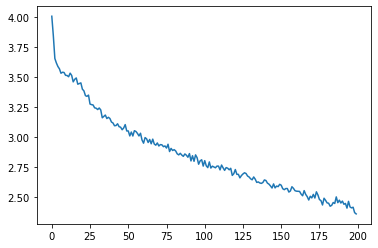

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [14]:
max_length = 20

# Sample from a category and starting letter
def sample(start_letter='A'):
    with t.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(input[-1], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(start_letter))
        
# make suer this oen works
def samples2(start_syll):
    for syll in start_syll:
        print(sample(syll))

In [15]:
samples2(['La','Lu','Me','MA'])

Larouree deory
Lureme
Meres
MALLEN


In [16]:
samples(['A','K','m','N','T','u','Z'])

ALLEN
KISAKI PROJECR feat.
manaro
NATEEN
THE DEAVE
ureme
Zeris


In [56]:
samples(['Sad'])

Sadela


In [195]:
samples('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

ALL
Beare
Cremill
Deary
EREAN HARA
Fairy
Garistich
HERA
IALL
Jeradell
Kieth
La'mana
Maria
NATERISA
Orphere
PERIST
Qielle
Ray darayort
SHEREN
THE SEAM ST PIATKUSPA
URE
Virel
Wareri
Xaristira
Yamera
Zeray
